# Siamese MLP
In this file we are building a Siamese network for one shot classification of the malwares
The twin network is made of multi layer perceptrons (MLP)
trainig is done on the pairs of classes from the malware dataset

This implementation of Siamese network is inspired from the keras examples
Reference: https://keras.io/examples/mnist_siamese/

In [2]:
# data manipulation libraries
import numpy as np
import random

# plotting with matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import keras, models, layers etc..
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K
from keras.regularizers import l2

# jobloib for pickeling, train test split
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

# define number of classes for one-shot learning
num_classes = 2        # 1 = malware and  0 = benign


In [3]:
# load the pre-processed data which is ndarray and labels
data = joblib.load(r"dataset\X_siamese-11110-12-12-1" )
labels = joblib.load(r"dataset\labels-11110" )
print(data.shape)
print(labels.shape)

(11110, 12, 12)
(11110,)


In [5]:
# split the data into train and test for making the training and validation pairs for one shot 
x_train, x_test, y_train, y_test = train_test_split(data , labels, test_size = 0.33 , random_state = 4)

In [6]:
# input shape would be same as data shape
input_shape = x_train.shape[1:]

input_shape

(12, 12)

In [7]:
# Create functions

# find euclidean distance between two vectors for distance layer of the Siamese Network
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# convert to the output shape
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

# create pairs for two data points 
def create_pairs(x, row_indices):
    
    pairs = []
    labels = []
    n = min([len(row_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = row_indices[d][i], row_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = row_indices[d][i], row_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

# Classification accuracy with a 0.5 threshold on distances
def compute_accuracy(y_true, y_pred):    
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

# Contrastive loss function
- a distance based loss function appropriate for Siamese n/w (instead prediction error based like logistic loss # or hinge loss for classification ). 
- tries to make sure that semantically similar instances stay close together - neighbors are pulled together and non-neighbors are pushed apart 
- It is calculated on pairs. Other example of similer loss funs - triplet loss.

- Good explanation https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e
- main ref: Contrastive loss from Hadsell-et-al.'06
http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf


In [11]:
# contrastive loss function
# y_pred = Dw; distance putput b/w two pairs
# y_true = 0 is if pairs are similer and 1 if not

def contrastive_loss(y_true, y_pred):
    # margin greater than 0; dissimiler pairs beyond this margin will not contribute to the loss
    # we only want to optimise the network based on pairs that are actually dissimilar , 
    # but the network thinks are fairly similar.
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


In [8]:
# base network for twin network
'''    - A good value for dropout in a hidden layer is between 0.5 and 0.8. Input layers use a larger dropout rate, 
    such as of 0.8
    '''
    
def create_base_network(input_shape):
    
    input = Input(shape=input_shape)
    # we have to feed straiht rows to the MLP based Siamese network,so convert into vector form
    x = Flatten()(input)
    
    # hidden layer with 32 nodes 
    x = Dense(32, activation='relu' )(x)
    # 50% dropout rate
    x = Dropout(0.5)(x)
    
    # last hidden layer 
    x = Dense(8, activation='relu')(x)
    
    # after this layer model will be followed by distance layer and then output layer
    return Model(input, x)

In [9]:
# create training and validation set for positve(same) and negative (different) pairs
row_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, row_indices)

row_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, row_indices)

# build base network 
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# As these are twin netowrks , so we the weights will be shared across the layers
# netowrk pair :-
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# calculate distance between processed data on a and b
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

# buld model
model = Model([input_a, input_b], distance)



In [12]:
model.compile(loss=contrastive_loss, optimizer=RMSprop(), metrics=[accuracy])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 12, 12)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 12, 12)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 8)            4904        input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]                    
          

In [21]:
# train
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=32,
          epochs=20,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))



Train on 14848 samples, validate on 7296 samples
Epoch 1/20
14848/14848 [==============================] - 1s 51us/step - loss: 0.0280 - accuracy: 0.9605 - val_loss: 0.0361 - val_accuracy: 0.9470
Epoch 2/20
14848/14848 [==============================] - 1s 48us/step - loss: 0.0267 - accuracy: 0.9622 - val_loss: 0.0368 - val_accuracy: 0.9450
Epoch 3/20
14848/14848 [==============================] - 1s 46us/step - loss: 0.0274 - accuracy: 0.9613 - val_loss: 0.0373 - val_accuracy: 0.9433
Epoch 4/20
14848/14848 [==============================] - 1s 46us/step - loss: 0.0268 - accuracy: 0.9609 - val_loss: 0.0353 - val_accuracy: 0.9486
Epoch 5/20
14848/14848 [==============================] - 1s 48us/step - loss: 0.0261 - accuracy: 0.9628 - val_loss: 0.0366 - val_accuracy: 0.9442
Epoch 6/20
14848/14848 [==============================] - 1s 47us/step - loss: 0.0270 - accuracy: 0.9617 - val_loss: 0.0364 - val_accuracy: 0.9457
Epoch 7/20
14848/14848 [==============================] - 1s 46us/ste

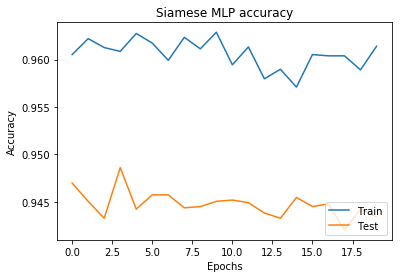

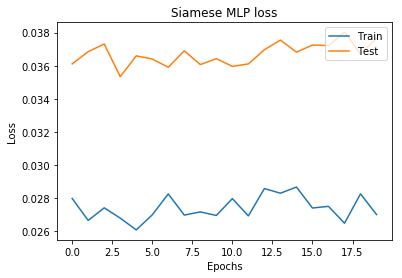

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Siamese MLP accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Siamese MLP loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [24]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
# training accuracy
tr_acc = compute_accuracy(tr_y, y_pred)

y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
# testing accuracy
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 97.45%
* Accuracy on test set: 94.34%


In [ ]:
from sklearn.externals import joblib
filepath = r"models\siamese-mlp"     
joblib.dump(model ,filepath )
siamese_mlp_val_acc = history.history['val_accuracy']
joblib.dump( history.history['val_accuracy'], r"results\siamese_mlp_val_acc" )